In [1]:
import sys
sys.path.append('../')

import tquant as tq
import tensorflow as tf

from datastore import *
# import datetime

tq.Settings.evaluation_date = date(2024, 4, 30)

# Market Instance

In [2]:
pillars = ir_eur_curve_estr['daycount'].values/365
tenors = ir_eur_curve_estr.tenor
rates = ir_eur_curve_estr['quote'].values
rate_curve = tq.RateCurve(pillars, rates, 'LINEAR')

calendar = tq.TARGET()

# Deposit

In [3]:
# rate_curve.set_rates(rates)

today = date(2024, 4, 30)

dc_convention = tq.DayCounterConvention.Actual360
spot_date = calendar.advance(today, 2, tq.TimeUnit.Days, dc_convention)
maturity = calendar.advance(spot_date, 1, tq.TimeUnit.Days, dc_convention)
quote = 0.03
deposit = tq.Deposit(tq.Currency.EUR, today, spot_date, maturity, 100, dc_convention, quote)

pricer = tq.DepositEngine(deposit)
pv_depo, tape = pricer.price_aad(rate_curve, today)
sensy_depo = tape.gradient(pv_depo, rate_curve.rates)
# print(pv_depo)
# print(sensy_depo)
sensy_depo = pd.DataFrame([tenors.tolist(), sensy_depo]).T
sensy_depo.columns = ['time', 'sensy']
sensy_depo.fillna(0, inplace = True)
sensy_depo.set_index('time', inplace = True)
sensy_depo['sensy'] = sensy_depo['sensy'].apply(tq.extract_value)

In [4]:
sensy_depo[sensy_depo['sensy'] != 0]

,sensy
time,
2BD,-0.821492
3BD,1.515595
1W,0.138833


# Overnight Indexed Swap (OIS)

In [5]:
## class helper
## input class helper
currency = tq.Currency.EUR
start_delay = 2
fixing_days = 2
period_fix_units = 1
period_fix = tq.TimeUnit.Years
bd_convention = tq.BusinessDayConvention.ModifiedFollowing
notional = 1.0
day_count_convention_fix = tq.DayCounterConvention.Actual360
day_count_convention_flt = tq.DayCounterConvention.Actual360

#### function build helper
#### input function build  
trade_date = tq.Settings.evaluation_date
quote = 0.01
term = 2
term_units = tq.TimeUnit.Years

if currency == tq.Currency.EUR:
    calendar = tq.TARGET()
else:
    raise TypeError("Calendar is not present for currency")

start_date = calendar.advance(trade_date,
                              start_delay, 
                              tq.TimeUnit.Days, 
                              bd_convention)
maturity = calendar.advance(start_date, term, term_units, bd_convention)

schedule_generator = tq.ScheduleGenerator(calendar, bd_convention)
schedule = schedule_generator.generate(start_date, 
                                           maturity, 
                                           period_fix_units, period_fix)

# start_fix = []
# end_fix = []
# pay_fix = []
# for i in range(len(schedule) - 1):
#     start_fix.append(schedule[i])
#     end_fix.append(schedule[i + 1])
#     pay_fix.append(calendar.adjust(schedule[i + 1], bd_convention))

day_count_fix = tq.DayCounter(day_count_convention_fix)
# day_count_flt = tq.DayCounter(day_count_convention_flt)

# start_flt = []
# end_flt = []
# pay_flt = []
# for i in range(len(schedule_float) - 1):
#     start_flt.append(schedule_float[i])
#     end_flt.append(schedule_float[i + 1])
#     pay_flt.append(calendar.adjust(schedule_float[i + 1], bd_convention))

# fixing_dates = []
# fixing_rates = []


index = tq.OvernightIndex('ESTR', calendar)

In [6]:
ois = tq.Ois(schedule,
             notional, 
             index, 
             quote,
             day_count_fix)
eng_ois = tq.OisAnalyticEngine(ois)

pv_ois, tape = eng_ois.price_aad(rate_curve, today)
sensy_ois = tape.gradient(pv_ois, rate_curve.rates)
print(pv_ois)
sensy_ois = pd.DataFrame([tenors.tolist(), sensy_ois]).T
sensy_ois.columns = ['time', 'sensy']
sensy_ois.fillna(0, inplace = True)
sensy_ois.set_index('time', inplace = True)
sensy_ois['sensy'] = sensy_ois['sensy'].apply(tq.extract_value)

tf.Tensor(0.047897643775294346, shape=(), dtype=float64)


In [7]:
sensy_ois[sensy_ois['sensy'] != 0]

,sensy
time,
2BD,-0.970262
3BD,1.790202
1W,0.163988
1Y,-11.277392
13M,12.195904
2Y,-0.037783
3Y,-0.001529


# QuantLib check

In [8]:
import QuantLib as ql
import matplotlib.pyplot as plt

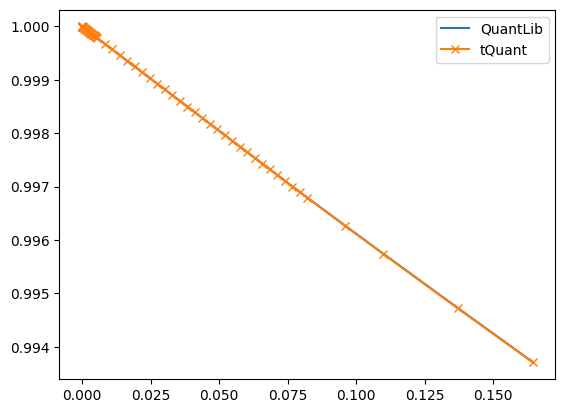

In [9]:
today_ql = ql.Date.from_date(today)
ql.Settings.instance().evaluationDate = today_ql
calendar_ql=ql.TARGET()

pillars_days = ir_eur_curve_estr['daycount'].tolist()
pillars_ql = [today_ql + d for d in pillars_days]

rate_curve_ql = ql.ZeroCurve(pillars_ql, rates, ql.ActualActual(ql.ActualActual.ISDA), calendar_ql)
yts = ql.YieldTermStructureHandle(rate_curve_ql)
df_ql = [rate_curve_ql.discount(d) for d in pillars/365]
df_tq = [rate_curve.discount(d).numpy() for d in pillars/365]

plt.plot(pillars/365, df_ql, label='QuantLib')
plt.plot(pillars/365, df_tq, label='tQuant', marker='x')
plt.legend()
plt.show()


In [10]:
convention_ql = ql.ModifiedFollowing
start_date_ql = ql.Date.from_date(start_date)
nominal = 1
schedule_ql = ql.MakeSchedule(start_date_ql, ql.Date.from_date(maturity), ql.Period('1Y'), calendar=calendar_ql, convention=convention_ql, forwards=True)
fixedRate_ql = 0.01
fixedDC_ql = ql.Actual360()
overnightIndex_ql = ql.Estr(yts)
ois_ql = ql.OvernightIndexedSwap(ql.OvernightIndexedSwap.Payer,
                                   nominal,
                                   schedule_ql,
                                   fixedRate_ql,
                                   fixedDC_ql,
                                   overnightIndex_ql)

In [11]:
engine = ql.DiscountingSwapEngine(yts)
ois_ql.setPricingEngine(engine)
ois_ql.NPV()

0.04219302987229101

In [12]:
pv_ois

<tf.Tensor: shape=(), dtype=float64, numpy=0.047897643775294346>

## Debugging vs Ql: scomporre lo swap e trovare differenze

fixed leg

In [13]:
ois_ql.fixedLegNPV()

-0.019330750828065058

In [14]:
eng_ois.npv_fixed

<tf.Tensor: shape=(), dtype=float64, numpy=0.01931451792517587>

In [15]:
dates_fixed_ql = []
amounts_fixed_ql = []
for cf in ois_ql.fixedLeg():
    dates_fixed_ql.append(cf.date())
    amounts_fixed_ql.append(cf.amount())

In [16]:
dates_fixed_ql

[Date(5,5,2025), Date(4,5,2026)]

In [17]:
ois.fixed_leg.display_flows()

,start_period,end_period,payment_date,notional,accrual,day_counter,rate,amount
0,2024-05-03,2025-05-05,2025-05-05,1.0,1.019444,Actual360,0.01,0.010194
0,2025-05-05,2026-05-04,2026-05-04,1.0,1.011111,Actual360,0.01,0.010111


floating leg

In [18]:
eng_ois.npv_float

<tf.Tensor: shape=(), dtype=float64, numpy=0.06721216170047022>

In [19]:
ois_ql.floatingLegNPV()

0.061523780700356065

In [20]:
dates_float_ql = []
amounts_float_ql = []
for cf in ois_ql.floatingLeg():
    dates_float_ql.append(cf.date())
    amounts_float_ql.append(cf.amount())

In [21]:
# tq
[rate_curve.forward_rate(d, calendar.advance(d, 6, 
                                             tq.TimeUnit.Months, 
                                             bd_convention), day_count_fix, trade_date) for d in schedule[1:] ]

[<tf.Tensor: shape=(), dtype=float64, numpy=0.02945168800279107>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.026695030984667596>]

In [38]:
# ql
ql_fwd = [rate_curve_ql.forwardRate(d, calendar_ql.advance(d, ql.Period("6M")), fixedDC_ql, ql.Continuous).rate() for d in dates_float_ql]
ql_accr = [fixedDC_ql.yearFraction(start_date_ql, d) for d in dates_float_ql]

In [39]:
##
# tq
tq_fwd = [rate_curve.forward_rate(d, calendar.advance(d, 6, 
                                             tq.TimeUnit.Months, 
                                             bd_convention), day_count_fix, trade_date) for d in schedule[1:] ]
tq_acc = [day_count_fix.year_fraction(start_date, d) for d in schedule[1:]]

In [40]:
accruals =ois.floating_leg.display_flows()['accrual'].values

In [41]:
notional * accruals[0] * ql_fwd[0]

0.029493570979877422

In [42]:
notional * accruals[1] * ql_fwd[1]

0.026583962569587987

In [46]:
notional * accruals[0] * tq_fwd[0] 

<tf.Tensor: shape=(), dtype=float64, numpy=0.03002435971395645>

In [44]:
notional * accruals[1] * tq_fwd[1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.02699164244005279>

In [55]:
ois.floating_leg.leg_flows()[0].accrual_period

1.0194444444444444

In [54]:
ois.floating_leg.display_flows()

,start_period,end_period,payment_date,notional,fixing_date,fixing_days,index,accrual,in_arrears,gearing,spread,day_counter
0,2024-05-03,2025-05-05,2025-05-05,1.0,2024-05-03,None,ESTR,1.019444,False,1.0,0.0,Actual360
0,2025-05-05,2026-05-04,2026-05-04,1.0,2025-05-05,None,ESTR,1.011111,False,1.0,0.0,Actual360


In [25]:
ois.floating_leg.display_flows()

,start_period,end_period,payment_date,notional,fixing_date,fixing_days,index,accrual,in_arrears,gearing,spread,day_counter
0,2024-05-03,2025-05-05,2025-05-05,1.0,2024-05-03,None,ESTR,1.019444,False,1.0,0.0,Actual360
0,2025-05-05,2026-05-04,2026-05-04,1.0,2025-05-05,None,ESTR,1.011111,False,1.0,0.0,Actual360
